In [31]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm
from absl import flags

## Relative imports
from astroddpm.runners import Diffuser, config_from_id
from astroddpm.separation import double_loader, method1_algo2, check_separation1score, separation1score, load_everything
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet

from astroddpm.analysis.validationMetrics.powerSpectrum import compare_separation_power_spectrum_iso

from scipy.signal import savgol_filter

import bm3d
from bm3d import bm3d, BM3DProfile, BM3DStages

In [32]:
MODEL_ID = 'DiscreteSBM_VPSDE_MHD_BPROJ_N_1000_bottleneck_32'

In [33]:
amin,amax=(-6, 6)
bins = np.linspace(0, np.pi, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
## Method 1
diffuser = load_everything(MODEL_ID)

## Method 2
# diffuser = Diffuser(DiscreteSBM(DiscreteVPSDE(1000),ResUNet()))
# config = config_from_id(MODEL_ID)
# diffuser2.load(config = config, also_ckpt=True)

No model id found
Looking for the diffuser corresponding to model_id DiscreteSBM_VPSDE_MHD_BPROJ_N_1000_bottleneck_32 in the MODELS.json all config file
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.


## One score source separation/denoising with gaussian fields (from standard gaussian to CMB gaussian random field)

In [35]:
t = 200

NUM_MAX_SAMPLES = 64
NUM_SAMPLES = 32

noise_strength = diffuser.diffmodel.sde.noise_level(t).item()
noise_strength


0.7235910892486572

In [36]:
truth_list, noisy_list, denoised_list = check_separation1score(diffuser, None, t, 1, NUM_SAMPLES, False)









































100%|██████████| 200/200 [00:04<00:00, 44.12it/s]


In [37]:
denoised_list[0].shape

torch.Size([32, 1, 256, 256])

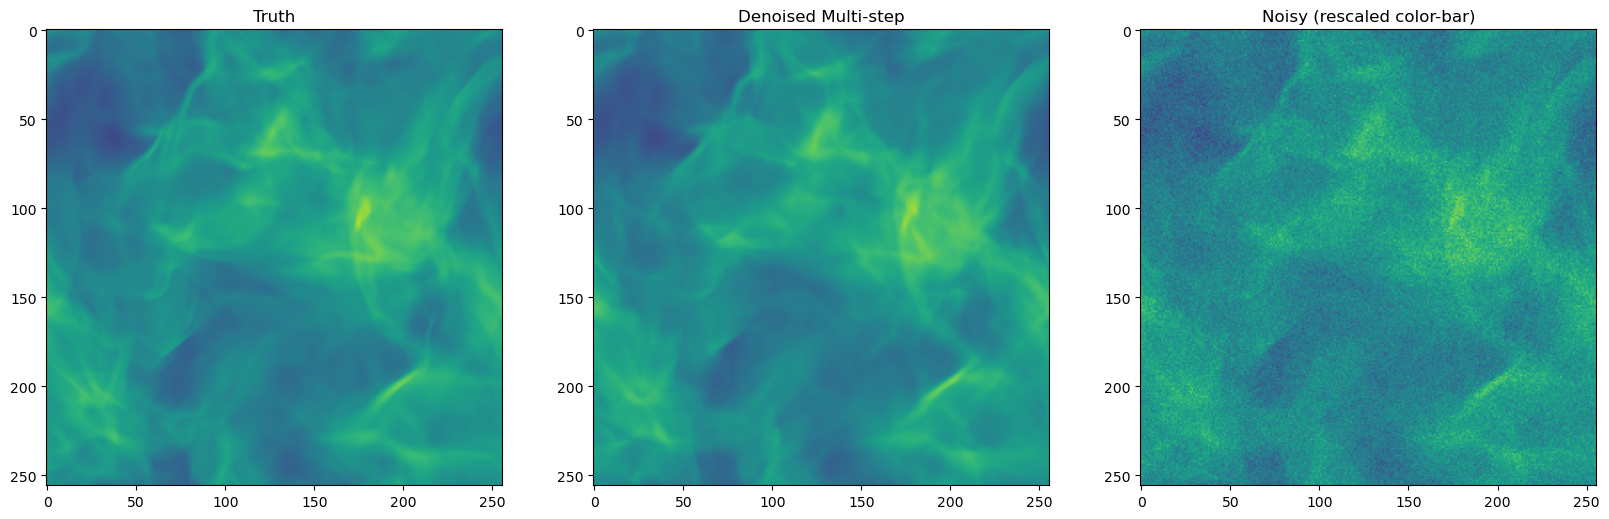

In [38]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth_list[0][0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised Multi-step')
ax[2].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

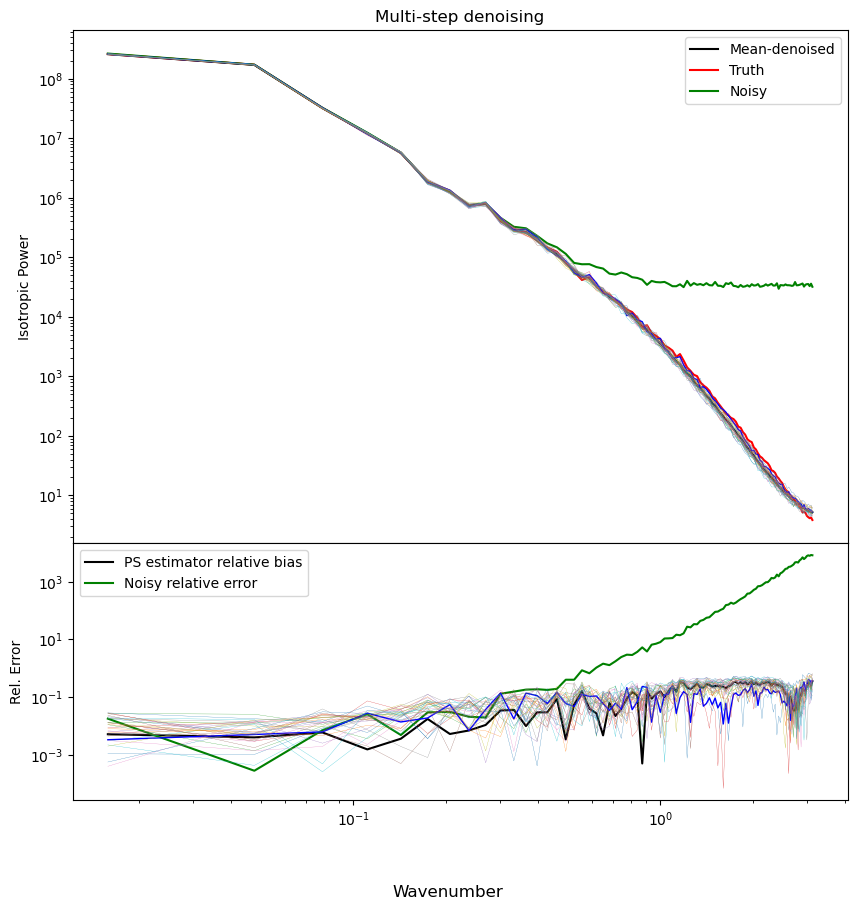

In [39]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth_list[0].to(device),denoised_list[0], noisy = noisy_list[0], only_trajectories= True, title= 'Multi-step denoising', relative_error= True, elementary_figsize=(10,10))

Check tweedie (one step denoising)

In [40]:
truth_list, noisy_list, denoised_list = check_separation1score(diffuser, None, t, 1, NUM_SAMPLES, True)

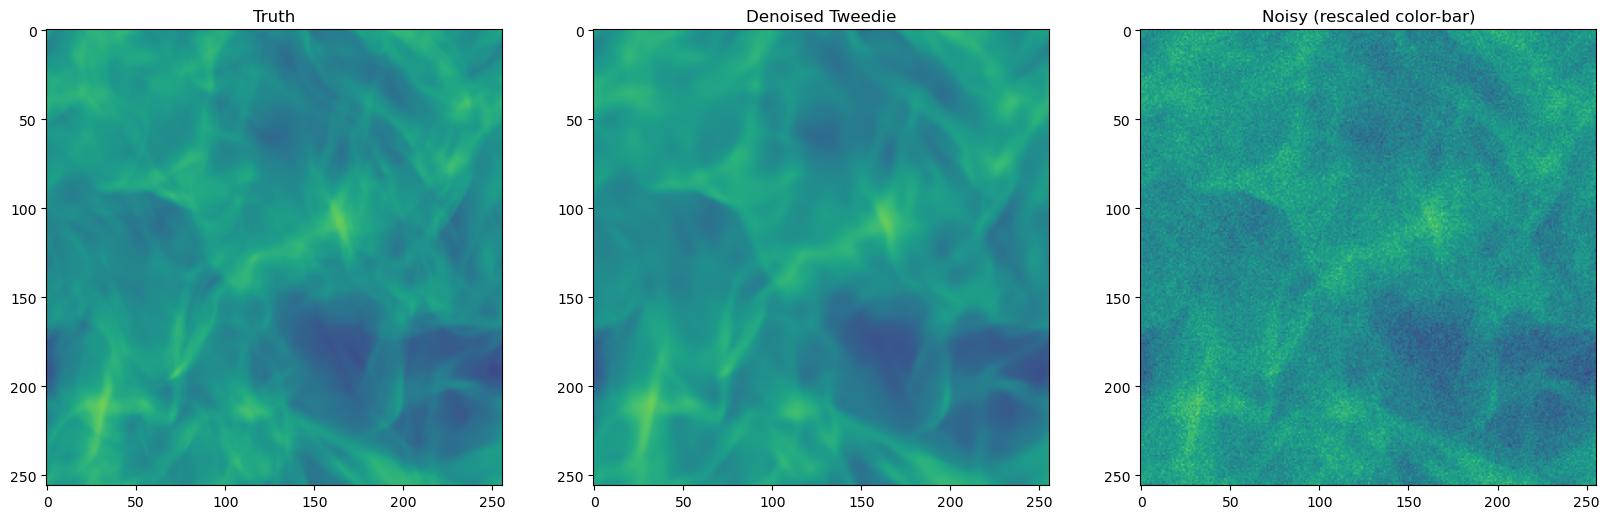

In [41]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth_list[0][0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised Tweedie')
ax[2].imshow(noisy_list[0][0][0].detach().cpu(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

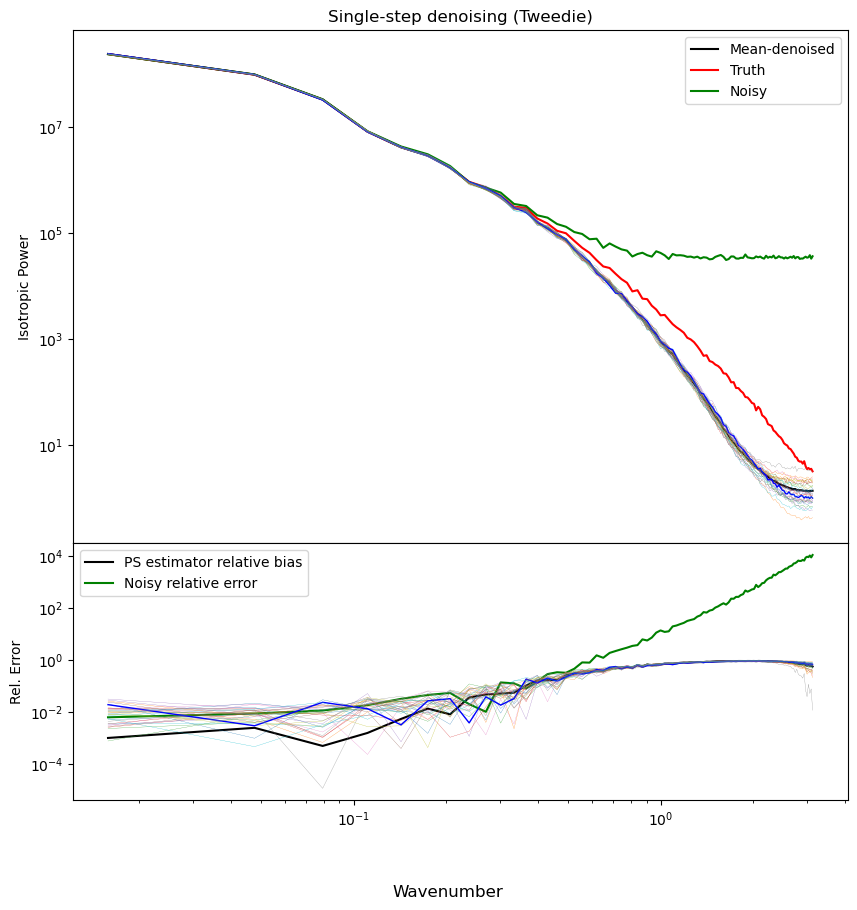

In [42]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth_list[0],denoised_list[0], noisy = noisy_list[0], only_trajectories= True, title = 'Single-step denoising (Tweedie)', elementary_figsize=(10,10), relative_error= True)

### BM3D

In [43]:
num_to_denoise = 1

In [44]:
testbatch1 = next(iter(diffuser.test_dataloader))
truth = testbatch1[:num_to_denoise].to(device)

if truth.ndim == 3:
    truth = truth.unsqueeze(1)

In [45]:
timesteps=torch.full((truth.shape[0],), t).long().to(device)
noise_strength

0.7235910892486572

In [46]:
observation , _ , _= diffuser.diffmodel.sde.sampling(truth, timesteps)
#observation = model1.sqrt_alphas_cumprod[noise_step]*truth + model1.sqrt_one_minus_alphas_cumprod[noise_step]*noise
observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, timesteps)
observation.shape

torch.Size([1, 1, 256, 256])

In [47]:
if isinstance(diffuser.diffmodel.sde, DiscreteVPSDE):
    power_spectrum = noise_strength
else:
    power_spectrum = diffuser.diffmodel.sde.power_spectrum.detach.cpu().numpy()
    power_spectrum *= noise_strength * power_spectrum.size

In [48]:
denoised_bm3d = bm3d(observation[0][0].cpu().detach().numpy(), sigma_psd = power_spectrum, stage_arg=BM3DStages.HARD_THRESHOLDING, )#stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING profile = 'refilter'

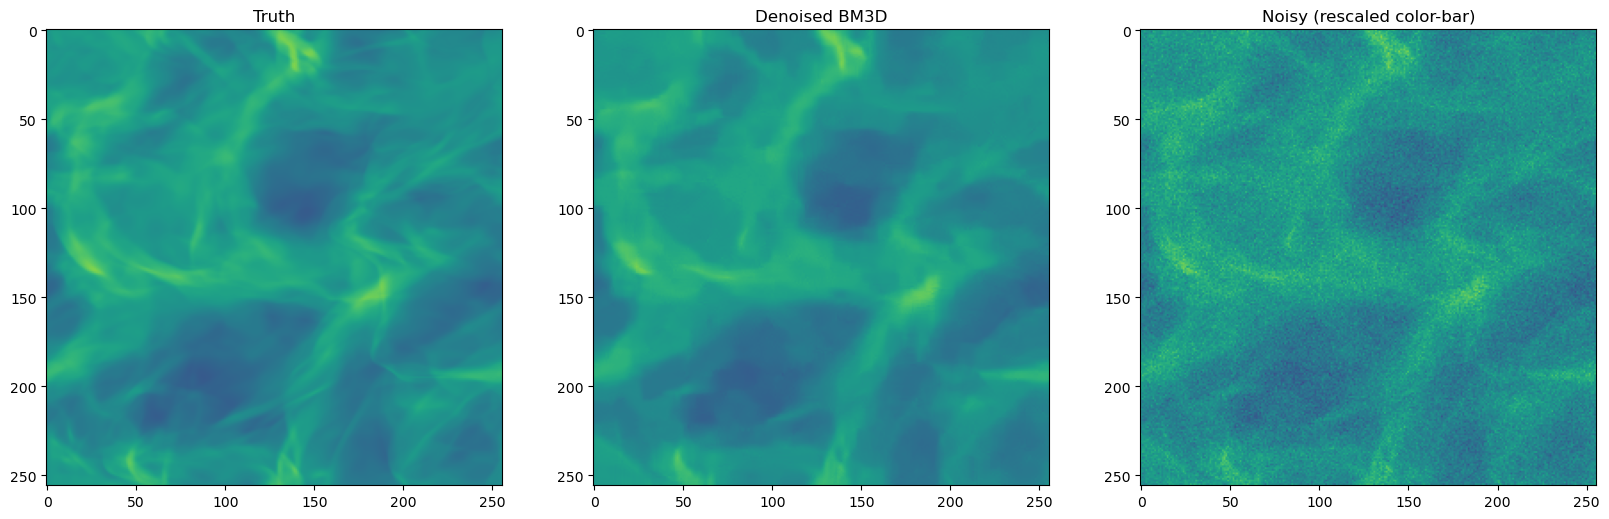

In [50]:
## Plot the truth, the bm3d_denoised image and the observation
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(truth[0][0].cpu().detach().numpy(),vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(denoised_bm3d,vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised BM3D')
ax[2].imshow(observation[0][0].cpu().detach().numpy(),vmin=np.sqrt(1+ noise_strength)*amin, vmax=np.sqrt(1+noise_strength)*amax)
ax[2].title.set_text('Noisy (rescaled color-bar)')

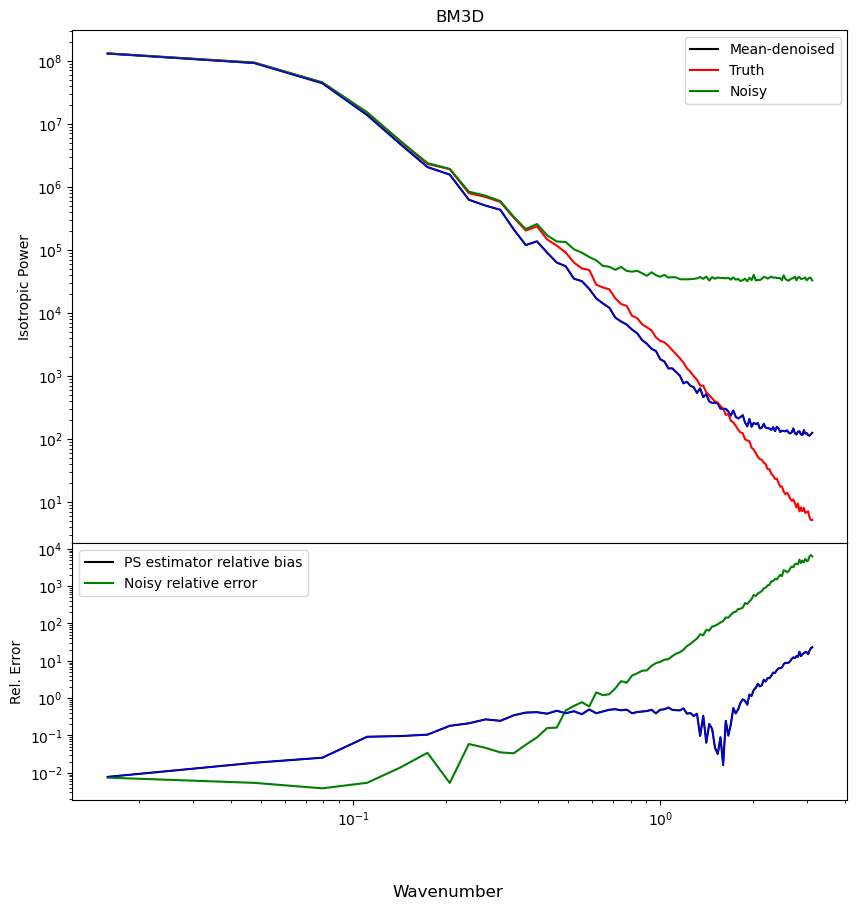

In [51]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(truth,torch.from_numpy(denoised_bm3d.reshape(1,1,256,256)), noisy = observation, only_trajectories= True, title = 'BM3D', elementary_figsize=(10,10), relative_error= True)

### Verify that MMSE estimator is mean of the conditional distribution after denoising

In [52]:
noisy_list, denoised_list = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=NUM_MAX_SAMPLES, tweedie=False, rescale_observation=True)

100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


In [53]:
noisy_list2, denoised_list2 = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)

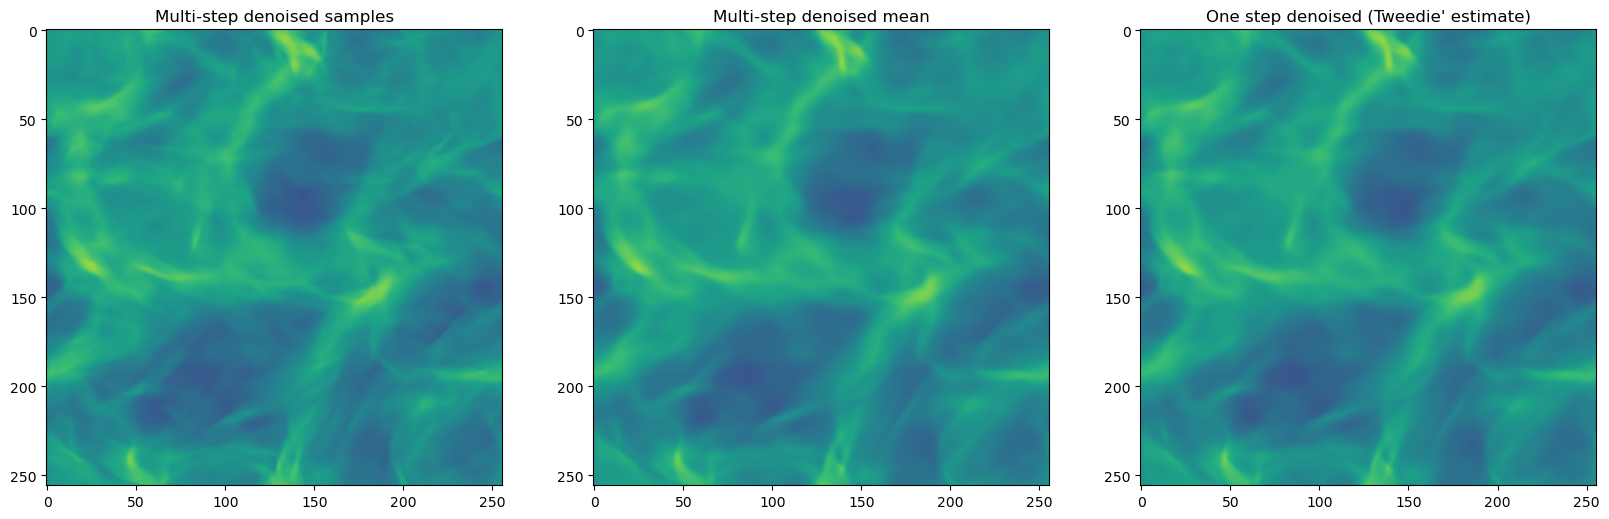

In [54]:
### MODIFIED COLOR BAR TO SEE MORE DETAILS
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(denoised_list[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[0].title.set_text('Multi-step denoised samples')
ax[1].imshow(denoised_list[0].mean(dim=0)[0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[1].title.set_text('Multi-step denoised mean')
ax[2].imshow(denoised_list2[0][0][0].detach().cpu(),vmin=amin*0.9, vmax=amax*0.9)
ax[2].title.set_text("One step denoised (Tweedie' estimate)")

In [56]:
print("L2 distance (squared) between Tweedie's estimate and average of multistep denoising : "+str(F.mse_loss(denoised_list2[0][0][0], denoised_list[0].mean(dim=0)[0]).detach().cpu().item()))
print("MSE between the multistep denoising distribution and Tweedie's estimate : "+str(F.mse_loss(denoised_list2[0][:1].repeat(NUM_MAX_SAMPLES,1 ,1, 1), denoised_list[0][:]).detach().cpu().item()))

L2 distance (squared) between Tweedie's estimate and average of multistep denoising : 0.0003408586489968002
MSE between the multistep denoising distribution and Tweedie's estimate : 0.01535799726843834


#### PSNR Computation

In [59]:
times = range(0, diffuser.diffmodel.sde.N, 100)
noise_level = diffuser.diffmodel.sde.noise_level(times)

max2_I = truth.square().max()

noisy_psnr_list = []
denoised_psnr_list = []
denoised_tweedies_psnr_list = []

noisy_snr_list = []
denoised_snr_list = []
denoised_tweedies_snr_list = []

for t in times:
    noise=torch.randn_like(truth)
    timesteps=torch.full((truth.shape[0],), t).long().to(device)

    observation , _, _ = diffuser.diffmodel.sde.sampling(truth, t)
    observation = diffuser.diffmodel.sde.rescale_preserved_to_additive(observation, t)

    _ , denoised_list = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=NUM_SAMPLES, tweedie=False, rescale_observation=True)
    _ , denoised_list2 = separation1score(diffuser, observation, noise_step=t, NUM_SAMPLES=1, tweedie=True, rescale_observation=True)
    
    PSNR_noisy = 10 * torch.log10(max2_I/F.mse_loss(observation,truth))
    PSNR_denoised = 10 * torch.log10(max2_I/F.mse_loss(denoised_list[0],truth.repeat(NUM_SAMPLES, 1, 1, 1)))
    PSNR_tweedie = 10 * torch.log10(max2_I/F.mse_loss(denoised_list2[0], truth))

    noisy_psnr_list.append(PSNR_noisy.detach().cpu().item())
    denoised_psnr_list.append(PSNR_denoised.detach().cpu().item())
    denoised_tweedies_psnr_list.append(PSNR_tweedie.detach().cpu().item())
    

0it [00:00, ?it/s]
100%|██████████| 900/900 [00:20<00:00, 44.22it/s]


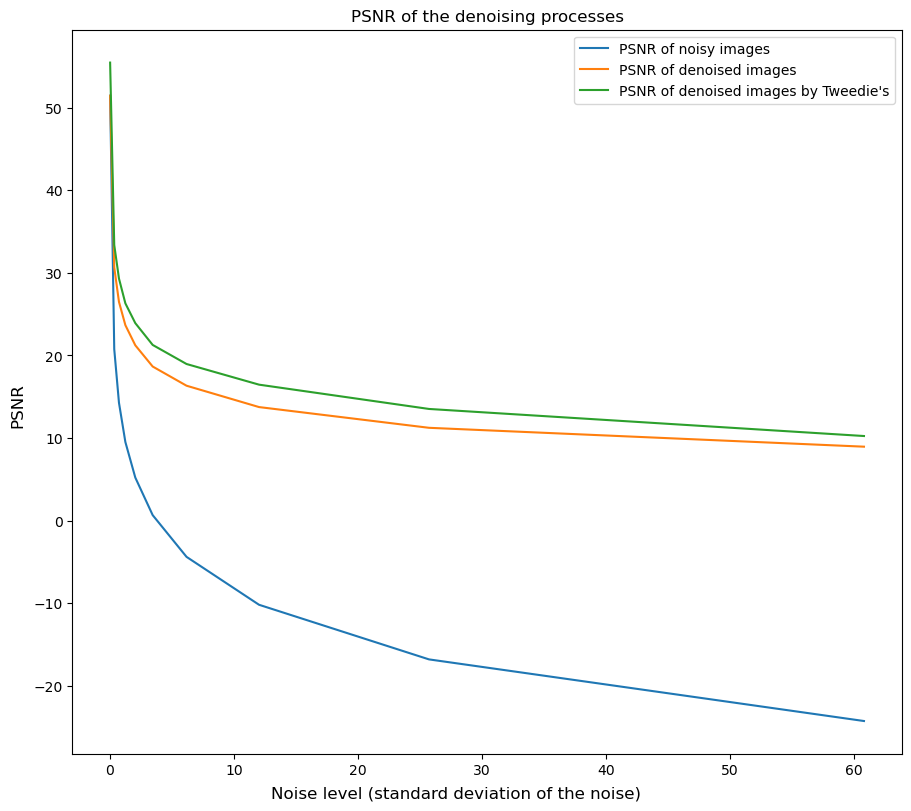

In [61]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
noises = noise_level.detach().cpu().reshape(-1)
ax.plot(noises, noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(noises, denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(noises, denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

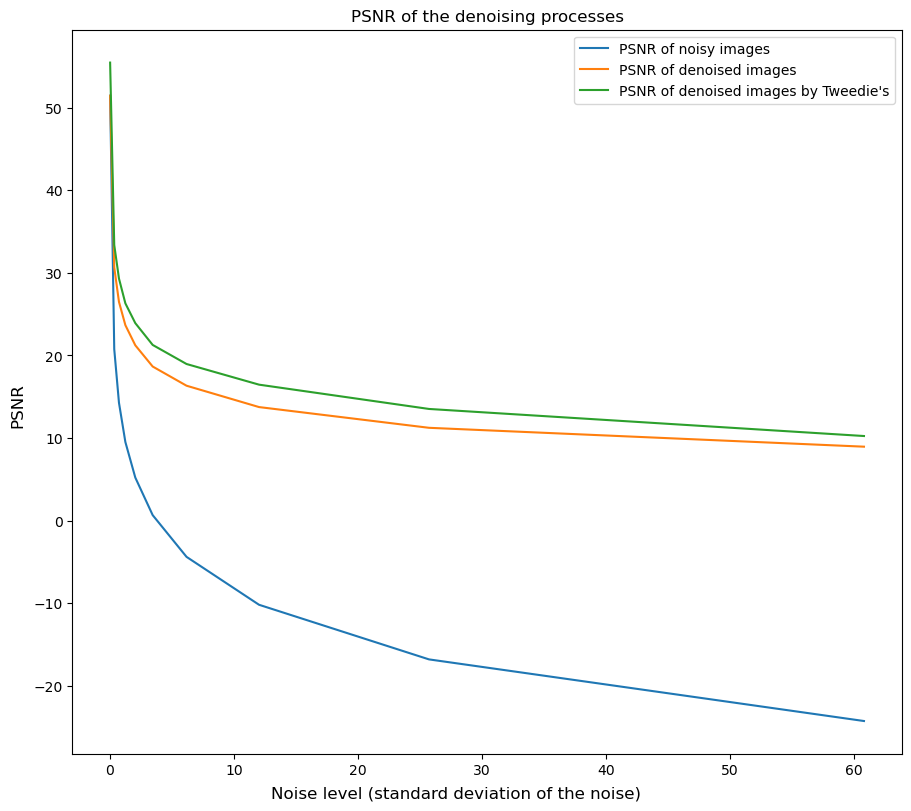

In [62]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(noises[:10], noisy_psnr_list[:10], label = 'PSNR of noisy images')
ax.plot(noises[:10], denoised_psnr_list[:10], label = 'PSNR of denoised images')
ax.plot(noises[:10], denoised_tweedies_psnr_list[:10], label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

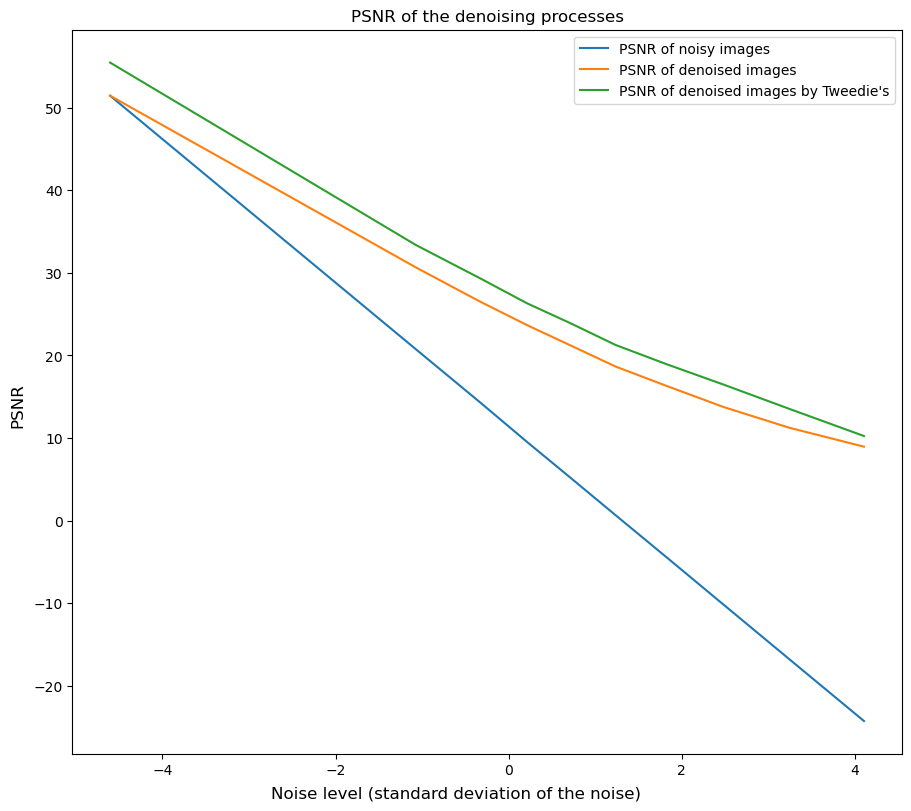

In [63]:
fig, ax= plt.subplots(1,1,figsize=(9,8), layout = 'constrained')
ax.plot(torch.log(noises), noisy_psnr_list, label = 'PSNR of noisy images')
ax.plot(torch.log(noises), denoised_psnr_list, label = 'PSNR of denoised images')
ax.plot(torch.log(noises), denoised_tweedies_psnr_list, label = "PSNR of denoised images by Tweedie's")
ax.legend()
fig.supylabel('PSNR')
fig.supxlabel('Noise level (standard deviation of the noise)')
ax.title.set_text('PSNR of the denoising processes')

# WORK IN PROGRESS

## Multi-score methods

Source separations methods here take two models as inputs.

In [ ]:
observation = testbatch1[0]+testbatch2[0]
observation = observation.unsqueeze(0)

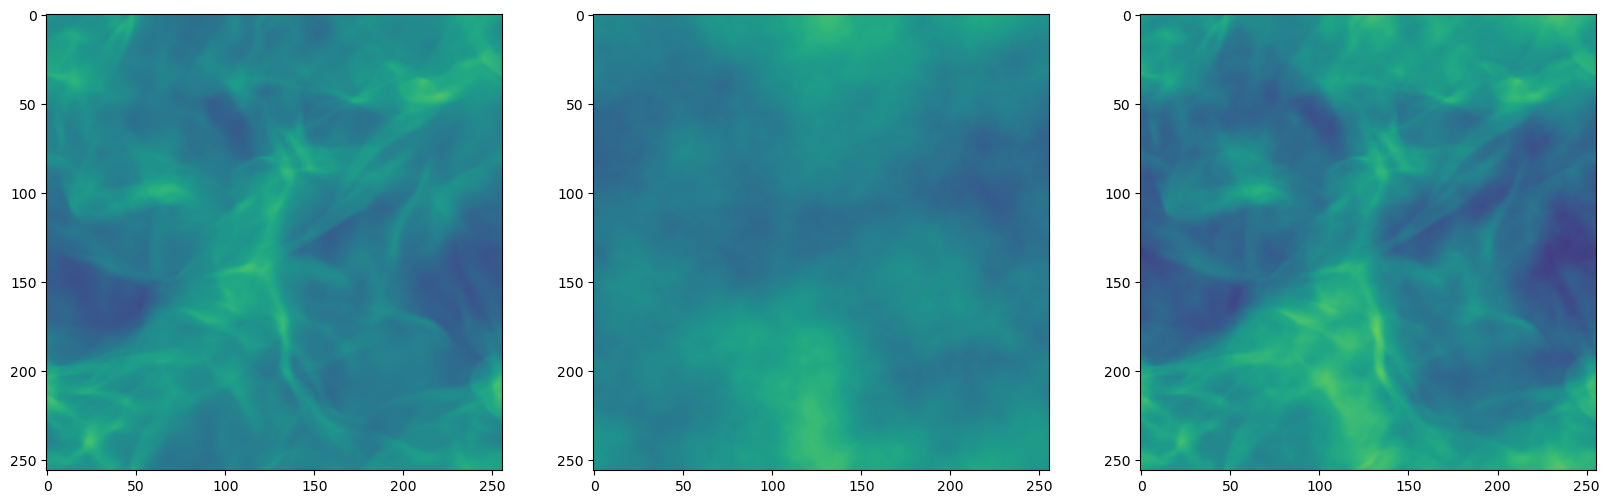

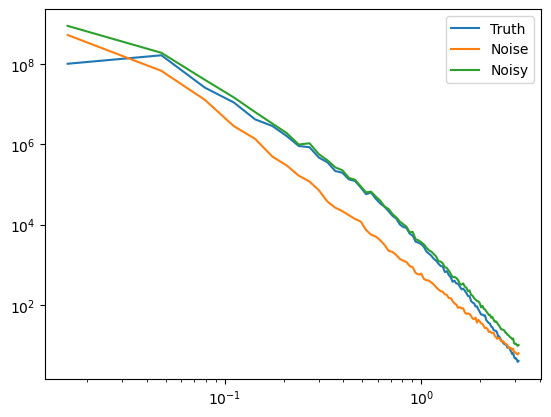

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[1].imshow(testbatch2[0][0],vmin=amin, vmax=amax)
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
plt.show()
_, b1, _ = power_spectrum_iso(testbatch1[0][0],bins=bins)
_, b2, _ = power_spectrum_iso(testbatch2[0][0],bins=bins)
_, b3, _ = power_spectrum_iso(observation[0][0].cpu(),bins=bins)
plot_ps(bins, [b1, b2, b3], ['Truth', 'Noise', 'Noisy'], show = True)

In [ ]:
sample, observation = method1_algo2(model1, model2, observation, NUM_SAMPLES=16)

100%|██████████| 2000/2000 [01:16<00:00, 26.27it/s]


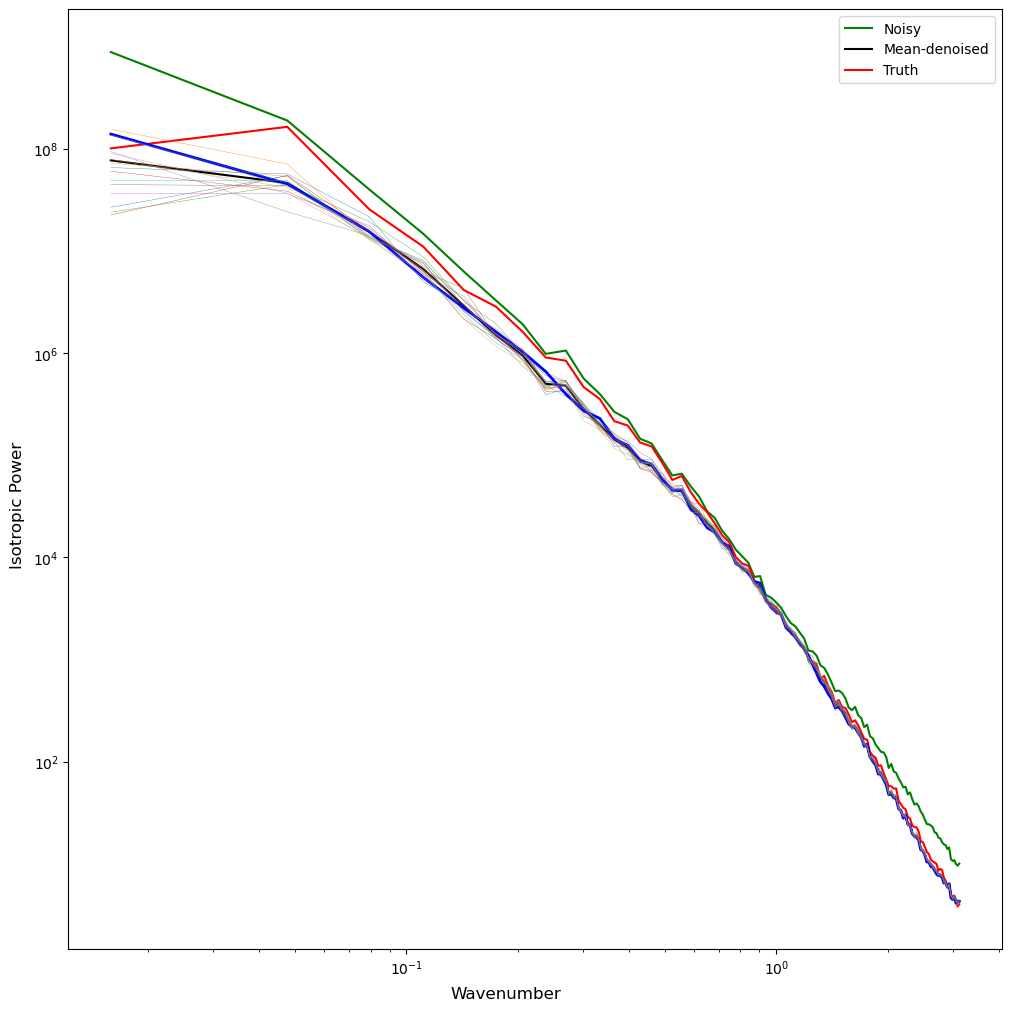

In [ ]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(testbatch1[0].unsqueeze(0),sample, noisy = observation, only_trajectories= True)

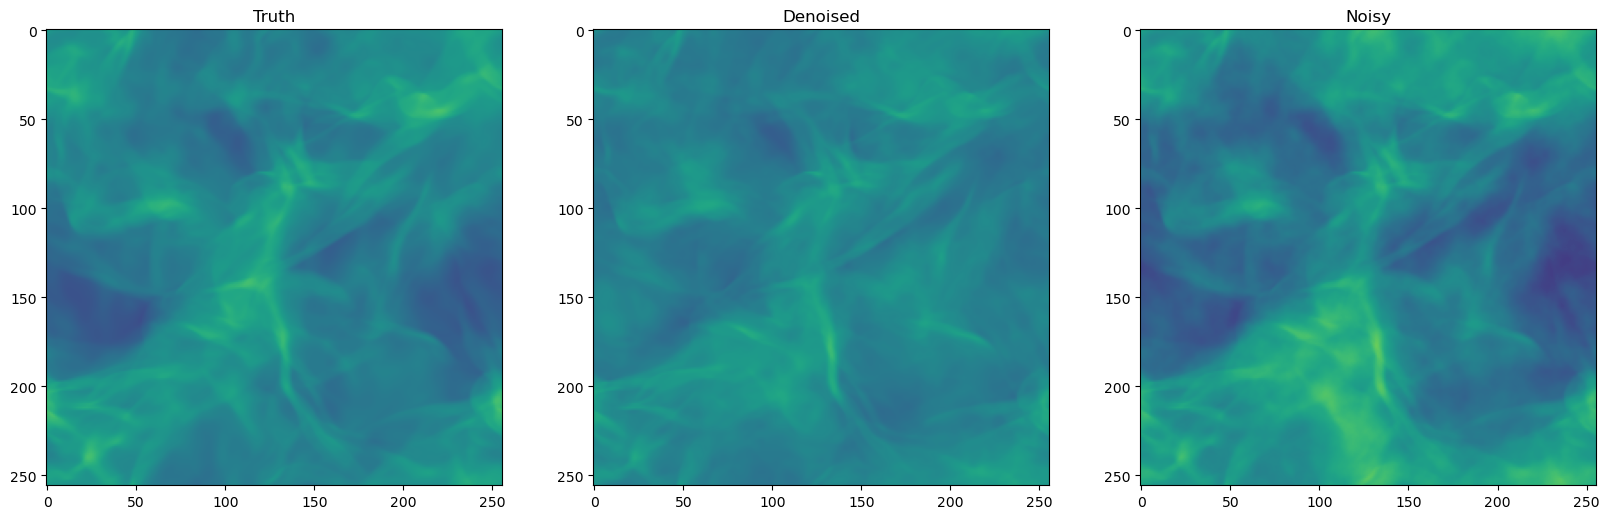

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(testbatch1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Truth')
ax[1].imshow(sample[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Denoised')
ax[2].imshow(observation[0][0],vmin=amin, vmax=amax)
ax[2].title.set_text('Noisy')
